In [1]:
# Cell 1: imports and settings
import pandas as pd
import numpy as np

# Modeling & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, accuracy_score,
    precision_score, recall_score, confusion_matrix,
    classification_report
)

# Stats (for VIF)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utilities
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# nice display settings
pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')

In [2]:
# Cell 2: load raw CSV
df_raw = pd.read_csv('Leads.csv')
df_raw.shape, df_raw.columns[:10]  # quick check

((9240, 37),
 Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
        'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
        'Total Time Spent on Website', 'Page Views Per Visit'],
       dtype='object'))

In [3]:
# Cell 3: cleaning (explain: convert 'Select' and blanks to NaN, drop IDs, drop >50% missing)
df = df_raw.copy()

# strip whitespace from column names
df.columns = [c.strip() for c in df.columns]

# standardize 'Select' and blanks -> NaN
df = df.replace(['Select', 'select', '', ' '], np.nan)

# Drop obvious ID columns
id_cols = [c for c in df.columns if 'id' in c.lower() or 'prospect' in c.lower() or 'lead number' in c.lower()]
print("Dropping ID-like columns:", id_cols)
df = df.drop(columns=id_cols)

# Drop columns with more than 50% missing values
missing_pct = df.isnull().mean()
cols_gt50 = missing_pct[missing_pct > 0.50].index.tolist()
print("Dropping >50% missing columns:", cols_gt50)
df = df.drop(columns=cols_gt50)

# quick peek
df.shape

Dropping ID-like columns: ['Prospect ID', 'Lead Number', 'How did you hear about X Education']
Dropping >50% missing columns: ['Lead Quality', 'Lead Profile']


(9240, 32)

In [4]:
# Cell 4: impute
df_imputed = df.copy()

# identify categorical vs numeric
cat_cols = df_imputed.select_dtypes(include='object').columns.tolist()
num_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()

# For non-tech audience: categorical missing -> "Unknown"
for c in cat_cols:
    df_imputed[c] = df_imputed[c].fillna('Unknown')

# numeric missing -> median (robust to outliers)
for c in num_cols:
    df_imputed[c] = df_imputed[c].fillna(df_imputed[c].median())

# confirm no missing left
df_imputed.isnull().sum().sum()

np.int64(0)

In [9]:
# Remove target variable if present inside numeric columns
if "Converted" in num_cols:
    num_cols.remove("Converted")

In [5]:
# Cell 5: target check and basic EDA
print("Rows, columns:", df_imputed.shape)
print("Converted value counts:\n", df_imputed['Converted'].value_counts(normalize=True).round(3))

# sample of numeric summaries
display(df_imputed[num_cols].describe().T.head(10))

# show top 10 categorical columns unique counts to decide encoding strategy
cat_nunique = df_imputed[cat_cols].nunique().sort_values(ascending=False)
display(cat_nunique.head(20))

Rows, columns: (9240, 32)
Converted value counts:
 Converted
0    0.615
1    0.385
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Converted,9240.0,0.385390,0.486714,0.0,0.0,0.0,1.0,1.0
TotalVisits,9240.0,3.438636,4.819024,0.0,1.0,3.0,5.0,251.0
Total Time Spent on Website,9240.0,487.698268,548.021466,0.0,12.0,248.0,936.0,2272.0
Page Views Per Visit,9240.0,2.357440,2.145781,0.0,1.0,2.0,3.0,55.0
Asymmetrique Activity Score,9240.0,14.166450,1.033585,7.0,14.0,14.0,14.0,18.0
Asymmetrique Profile Score,9240.0,16.187446,1.346358,11.0,16.0,16.0,16.0,20.0


Country                                          39
Tags                                             27
Lead Source                                      22
Specialization                                   19
Last Activity                                    18
Last Notable Activity                            16
What is your current occupation                   7
City                                              7
Lead Origin                                       5
What matters most to you in choosing a course     4
Asymmetrique Activity Index                       4
Asymmetrique Profile Index                        4
Do Not Call                                       2
Do Not Email                                      2
Search                                            2
Newspaper Article                                 2
Newspaper                                         2
X Education Forums                                2
A free copy of Mastering The Interview            2
Through Reco

In [6]:
# Cell 6: reduce cardinality then one-hot encode
df_enc = df_imputed.copy()

# function to keep top k categories, convert others to 'Other'
def top_k_to_other(series, k=10):
    top = series.value_counts().nlargest(k).index
    return series.where(series.isin(top), other='Other')

# choose columns to reduce (those with >10 unique categories)
for c in cat_cols:
    if df_enc[c].nunique() > 10:
        df_enc[c] = top_k_to_other(df_enc[c], k=10)

# Now one-hot encode all categorical columns
df_final = pd.get_dummies(df_enc, columns=cat_cols, drop_first=True)

print("After encoding:", df_final.shape)

After encoding: (9240, 100)


In [7]:
# Cell 7: X/y and split
X = df_final.drop(columns=['Converted'])
y = df_final['Converted'].astype(int)

# stratify to keep class distribution same in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (6468, 99) Test shape: (2772, 99)


In [10]:
# Select numeric columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target column
if "Converted" in num_cols:
    num_cols.remove("Converted")

# VIF only for numeric independent variables
X_vif = X_train[num_cols].copy()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant
X_vif_const = sm.add_constant(X_vif)

# Create VIF table
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif_const.values, i) 
                   for i in range(X_vif_const.shape[1])]

vif_data.sort_values("VIF", ascending=False).head(15)

,feature,VIF
0,const,365.648528
3,Page Views Per Visit,1.415434
1,TotalVisits,1.320654
2,Total Time Spent on Website,1.118821
5,Asymmetrique Profile Score,1.032528
4,Asymmetrique Activity Score,1.021200


In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

pipeline.fit(X_train, y_train)

y_proba_test = pipeline.predict_proba(X_test)[:, 1]
y_pred_test = pipeline.predict(X_test)

print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba_test), 3))
print("Test Accuracy:", round(accuracy_score(y_test, y_pred_test), 3))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test, digits=3))

Test ROC-AUC: 0.979
Test Accuracy: 0.935

Classification Report:

              precision    recall  f1-score   support

           0      0.936     0.960     0.948      1704
           1      0.934     0.896     0.914      1068

    accuracy                          0.935      2772
   macro avg      0.935     0.928     0.931      2772
weighted avg      0.935     0.935     0.935      2772



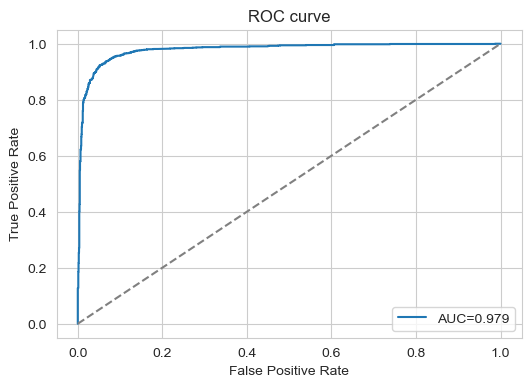

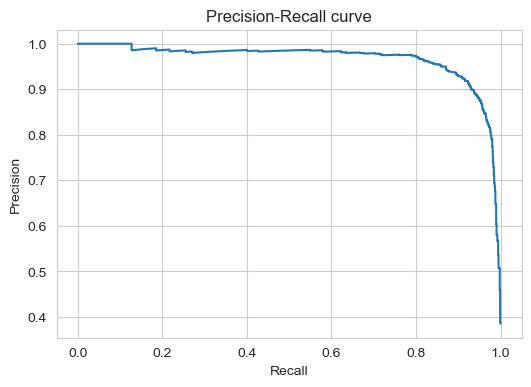

In [13]:
# Cell 10: ROC and precision-recall curves
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba_test):.3f}")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

In [14]:
# Cell 11: map probabilities to lead score (0-100)
# We'll create a DataFrame with test rows and their predicted probabilities
df_scores = X_test.copy()
df_scores['true_converted'] = y_test.values
df_scores['pred_proba'] = y_proba_test
df_scores['lead_score'] = (df_scores['pred_proba'] * 100).round(2)  # 0-100 scale
df_scores = df_scores.sort_values('lead_score', ascending=False)

# show top 10 predicted hot leads in test set
display(df_scores[['lead_score', 'pred_proba', 'true_converted']].head(10))

,lead_score,pred_proba,true_converted
4693,100.00,0.999966,1
8867,100.00,0.999965,1
2656,100.00,0.999978,1
4830,100.00,0.999966,1
7987,100.00,0.999951,1
2195,100.00,0.999974,1
8541,100.00,0.999961,1
3710,99.99,0.999935,1
7636,99.99,0.999947,1
3829,99.99,0.999929,1


In [18]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# 1. Generate a list of thresholds to test (0.0 to 1.0)
thresholds = np.linspace(0, 1, 200)

results = []

for thr in thresholds:
    y_pred_thr = (y_proba_test >= thr).astype(int)

    # Avoid errors when no leads are selected
    if y_pred_thr.sum() == 0:
        continue

    precision = precision_score(y_test, y_pred_thr)  # conversion rate
    recall = recall_score(y_test, y_pred_thr)
    selected = y_pred_thr.sum()

    results.append([thr, precision, recall, selected])

# Convert to DataFrame
threshold_df = pd.DataFrame(results, columns=["threshold", "precision", "recall", "selected"])

# 2. Find threshold closest to 80% precision (0.80)
target_precision = 0.80
threshold_df["precision_diff"] = abs(threshold_df["precision"] - target_precision)

best_row = threshold_df.loc[threshold_df["precision_diff"].idxmin()]

best_threshold = best_row["threshold"]
best_precision = best_row["precision"]
best_recall = best_row["recall"]
best_selected = int(best_row["selected"])

# 3. Print results
print("=== Recommended Threshold for ~80% Conversion ===")
print(f"Threshold: {best_threshold}")
print(f"Expected Conversion Rate (Precision): {best_precision}")
print(f"Recall (Captured Converters): {best_recall}")
print(f"Leads Selected: {best_selected}")

# Show first few rows for reference
threshold_df.head()

=== Recommended Threshold for ~80% Conversion ===
Threshold: 0.10050251256281408
Expected Conversion Rate (Precision): 0.7969465648854962
Recall (Captured Converters): 0.9775280898876404
Leads Selected: 1310


,threshold,precision,recall,selected,precision_diff
0,0.000000,0.385281,1.000000,2772,0.414719
1,0.005025,0.464690,0.998127,2294,0.335310
2,0.010050,0.519297,0.995318,2047,0.280703
3,0.015075,0.548837,0.994382,1935,0.251163
4,0.020101,0.568670,0.992509,1864,0.231330


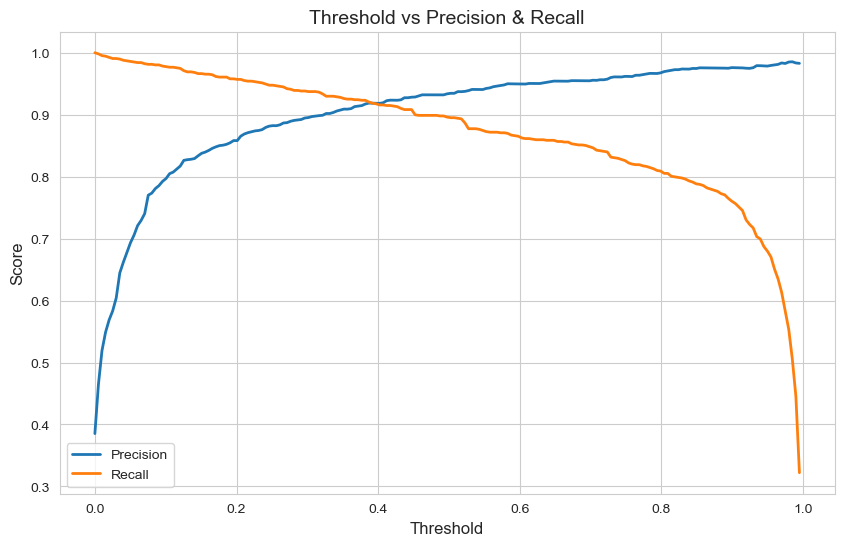

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 200)

precisions = []
recalls = []

for thr in thresholds:
    y_pred_thr = (y_proba_test >= thr).astype(int)

    # Skip thresholds where no leads are selected
    if y_pred_thr.sum() == 0:
        precisions.append(np.nan)
        recalls.append(np.nan)
        continue
    
    precisions.append(precision_score(y_test, y_pred_thr))
    recalls.append(recall_score(y_test, y_pred_thr))


# ==== PLOT ====
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)

plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Threshold vs Precision & Recall", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [20]:
import joblib

# Save the trained pipeline
joblib.dump(pipeline, 'x_education_logreg_pipeline.joblib')

# Save the columns used in the model (important for scoring new data)
import pandas as pd
pd.Series(X_train.columns).to_csv('model_features.csv', index=False)

print("Model pipeline saved as 'x_education_logreg_pipeline.joblib'")
print("Feature list saved as 'model_features.csv'")

Model pipeline saved as 'x_education_logreg_pipeline.joblib'
Feature list saved as 'model_features.csv'


In [21]:
# Predict probabilities for all leads (or test set)
y_proba_test = pipeline.predict_proba(X_test)[:, 1]

# Convert probabilities to lead scores 0-100
lead_scores = (y_proba_test * 100).round(2)

# Create a DataFrame to export
export_df = pd.DataFrame({
    "Lead_Index": X_test.index,
    "Lead_Score_0_to_100": lead_scores
})

# Save to CSV
export_df.to_csv('lead_scores_export.csv', index=False)

print("Lead scores saved as 'lead_scores_export.csv'")

Lead scores saved as 'lead_scores_export.csv'


In [16]:
# Cell 13: save model and feature list
joblib.dump(pipeline, 'x_education_logreg_pipeline.joblib')
# it's also useful to save the columns order for future predictions
pd.Series(X_train.columns).to_csv('model_features.csv', index=False)
print("Saved pipeline as x_education_logreg_pipeline.joblib and features as model_features.csv")

Saved pipeline as x_education_logreg_pipeline.joblib and features as model_features.csv


In [17]:
# Cell 14: example of scoring new leads (new_leads_df must have same columns as X_train)
# new_leads_df = pd.read_csv('new_leads.csv')  # example
# load pipeline
# pipeline = joblib.load('x_education_logreg_pipeline.joblib')
# Prepare new_leads to have same dummy/columns/encoding as training data:
#  - apply same cleaning and top-k bucketing for categorical columns
#  - then create dummies and reindex to X_train.columns (filling missing cols with 0)

def prepare_new_leads(new_df, X_train_cols, cat_cols_names):
    df_new = new_df.copy()
    df_new.columns = [c.strip() for c in df_new.columns]
    df_new = df_new.replace(['Select','select','', ' '], np.nan)
    # drop id-like and previously dropped columns accordingly (match preprocessing)
    for c in cat_cols_names:
        if c in df_new.columns and df_new[c].nunique() > 10:
            df_new[c] = top_k_to_other(df_new[c], k=10)
    # fill missing
    for c in df_new.select_dtypes(include='object').columns:
        df_new[c] = df_new[c].fillna('Unknown')
    for c in df_new.select_dtypes(include=[np.number]).columns:
        df_new[c] = df_new[c].fillna(df_new[c].median())
    df_new = pd.get_dummies(df_new, columns=df_new.select_dtypes(include='object').columns, drop_first=True)
    # reindex to model features
    df_new = df_new.reindex(columns=X_train_cols, fill_value=0)
    return df_new

# scoring:
# prepared = prepare_new_leads(new_leads_df, X_train.columns.tolist(), cat_cols)
# probs = pipeline.predict_proba(prepared)[:,1]
# scores = (probs*100).round(2)

In [26]:
# Assistant
# on your machine (where the model was trained)
import joblib, cloudpickle
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Create your actual pipeline here instead of using the placeholder
# This is just an example - replace with your specific pipeline components
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Train your pipeline here with your data
# pipe.fit(X_train, y_train)

# Option A: using joblib + cloudpickle
with open("x_education_logreg_pipeline_cloudpickle.pkl", "wb") as f:
    cloudpickle.dump(pipe, f)

# Option B: joblib with specific protocol
joblib.dump(pipe, "x_education_logreg_pipeline.joblib", protocol=4)

['x_education_logreg_pipeline.joblib']